In [2]:
import keras 
from keras.layers import LSTM,Dense,Conv1D,MaxPooling1D
from keras.models import Sequential,Model
from gensim.models import Word2Vec
from keras.layers import Bidirectional,TimeDistributed
import numpy as np
import codecs
import regex
import  matplotlib.pyplot as plt

In [3]:
data_div=1
sent=[]
tags=[]
with codecs.open("v1_train.ml","r",encoding="utf-8") as f:
    l1=[]
    l2=[]
    for i in f:
        x=i.split()
        if(x[0]=="newline"):
            sent.append(l1)
            tags.append(l2)
            l1=[]
            l2=[]
        else:
            l1.append(x[0])
            l2.append(x[1])

In [4]:
print(len(sent))
tag_count=0
for i in tags:
    for j in i:
        if(j!="other"):
            tag_count+=1
print(tag_count)
tag_map={'datenum': 0,
 'event': 0,
 'location': 0,
 'name': 0,
 'number': 0,
 'occupation': 0,
 'organization': 0,
 'other': 0,
 'things': 0}
for i in tags:
    for j in i:
        tag_map[j]+=1
print(tag_map)
print()

65188
136669
{'name': 59422, 'organization': 4841, 'location': 29371, 'other': 701664, 'things': 1999, 'datenum': 1609, 'event': 837, 'occupation': 8037, 'number': 30553}



In [69]:
from sklearn.model_selection import train_test_split
sent,pre_x_test,tags,pre_y_test=train_test_split(sent,tags,test_size=0.1,random_state=1)
print(len(sent))
print(len(tags))
print(len(pre_x_test))
print(len(pre_y_test))

/home/sagar/tensorflow/lib/python3.5/importlib/_bootstrap.py:222: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/home/sagar/tensorflow/lib/python3.5/importlib/_bootstrap.py:222: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)


58669
58669
6519
6519


0 : 15293
1 : 14475
2 : 10700
3 : 6680
4 : 4277
5 : 2624
6 : 1589
7 : 1086
8 : 670
9 : 439
10 : 302
11 : 180
12 : 109
13 : 60
14 : 50
15 : 39
16 : 22
17 : 13
18 : 13
19 : 14
20 : 5
21 : 6
22 : 3
23 : 6
24 : 2
26 : 1
27 : 2
29 : 1
31 : 1
33 : 2
34 : 3
62 : 1
123 : 1


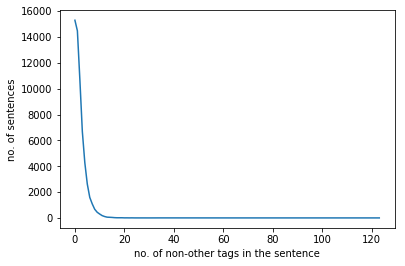

In [70]:
def get_data_distribution(sent,tags):
    cnt_dict={}
    for i in tags:
        cnt=0
        for j in i:
            if(j!="other"):
                cnt+=1
        if(cnt in cnt_dict):
            cnt_dict[cnt]+=1
        else:
            cnt_dict[cnt]=1
    cnt_list=list(cnt_dict.keys())
    cnt_list.sort()
    l1=[]
    l2=[]
    for i in cnt_list:
        print(i,":",cnt_dict[i])
        l1.append(i)
        l2.append(cnt_dict[i])
    plt.plot(l1,l2)
    plt.xlabel("no. of non-other tags in the sentence")
    plt.ylabel("no. of sentences")
    plt.show()
get_data_distribution(sent,tags)

In [71]:
def filter_data(sent,tags,exclude_list):
    sent_filter=[]
    tags_filter=[]
    for i in range(len(tags)):
    #     print(tags[i])
        cnt=0
        for j in tags[i]:
            if(j!="other"):
                cnt+=1
        if(cnt in exclude_list):
            continue
        if(cnt>=0):
            sent_filter.append(sent[i])
            tags_filter.append(tags[i])
    return sent_filter,tags_filter
sent_filter,tags_filter=filter_data(sent,tags,[])
print(len(sent_filter))
print(len(tags_filter))

58669
58669


In [72]:
sent=sent_filter
tags=tags_filter
def divide_data_pactise(sent,tags,data_div):
    print("initial_len=",len(sent))
    sent=sent[:len(sent)//data_div]
    tags=tags[:len(tags)//data_div]
    return sent,tags
sent,tags=divide_data_pactise(sent,tags,data_div)
print("new_len=",len(sent))

initial_len= 58669
new_len= 58669


In [73]:
for i in sent[:10]:
    print(i)

['അദ്ദേഹം', 'ജനിച്ചത്', 'തമിഴ്', 'നാട്', 'സംസ്ഥാനത്തിലെ', 'മധുരയില്', 'ആണ്', '.']
['ലോകത്തിലെ', 'ഏറ്റവും', 'മഹത്തായ', 'കൃതികളിൽ', 'ഒന്നായി', 'വിശേഷിക്കപ്പെടുന്ന', 'ഒരു', 'സഞ്ചാര', 'നോവൽ', 'ആണ്', 'റോബിൻസൺ', 'ക്രൂസോ', 'ഇംഗ്ലീഷ്', 'പത്ര', 'പ്രവർത്തകനും', 'നോവലിസ്റ്റും', 'ലഘു', 'ലേഖാകാരനും', 'ആയ', 'ഡാനിയൽ', 'ഡീഫോ', 'ആണ്', 'ഈ', 'പ്രശസ്ത', 'ഗ്രന്ഥത്തിന്റെ', 'കർത്താവു', '.']
['2012', 'ലെ', 'പശ്ചാത്തലസംഗീതത്തിന്', 'ഉള്ള', 'ദേശീയ', 'ചലച്ചിത്രപുരസ്കാരം', 'നേടിയ', 'സംഗീതസംവിധായകന്', 'ആണ്', 'ബിജിബാൽ', 'ജനനം', '.']
['ഗുലാൻ', 'പരിശ്', 'അഥവാ', 'തുറുപ്പുകളി', 'വിഭാഗത്തിൽപ്പെട്ട', 'ഏറ്റവും', 'അടിസ്ഥാനപരം', 'ആയ', 'ചീട്ടുകളി', 'ആണ്', 'ഇരുപത്തിയെട്ട്', '.']
['ഒഡിഎഫ്', 'പിൻതുണ', 'ഉള്ള', 'ഒരു', 'കമ്പനി', 'ഇതര', 'സ്വതന്ത്ര', 'ഓഫീസ്', 'പാക്കേജ്', 'നിർമ്മിക്കുക', 'എന്നത്', 'ആണ്', 'ലിബ്രേഓഫീസിന്റെ', 'പ്രധാന', 'ലക്ഷ്യം', '.']
['അതിന്റെ', 'പ്രയോഗത്തിലും', 'ഗുണത്തിലും', 'എ', 'എസ്', 'പി', ',', 'പി', 'എച്ച്', 'പി', ',', 'ജെ', 'എസ്', 'പി', '.']
['ഭദ്രഭഗവതിയുടെ', 'ഉത്സവചടങ്ങുകളും', ',', 'ഭുവനേശ്വരിയുടെ', 'പൂജാവിധികളും

In [74]:
max_sent_len=-1
for i in sent:
    if(len(i)>max_sent_len):
        max_sent_len=len(i)
print("max_sent_len",max_sent_len)
avg_sent_len=0
for i in sent:
    avg_sent_len+=len(i)
avg_sent_len=avg_sent_len/len(sent)
print("avg_sent_len",avg_sent_len)
max_len=int(2*(avg_sent_len))
print("max_sent_len_fit",max_len)

max_sent_len 233
avg_sent_len 12.867510951268983
max_sent_len_fit 25


In [75]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.preprocessing.sequence import pad_sequences

In [76]:
# regex.findall(r'\X', sent[0][0])
def separate_into_char(sent):
    char=[]
    for i in sent:
        for j in i:
            l=regex.findall(r'\X',j)
            char.append(l)
    return char
char=separate_into_char(sent)

In [77]:

for i in char[:10]:
    print(i)


['അ', 'ദ്', 'ദേ', 'ഹം']
['ജ', 'നി', 'ച്', 'ച', 'ത്']
['ത', 'മി', 'ഴ്']
['നാ', 'ട്']
['സം', 'സ്', 'ഥാ', 'ന', 'ത്', 'തി', 'ലെ']
['മ', 'ധു', 'ര', 'യി', 'ല്']
['ആ', 'ണ്']
['.']
['ലോ', 'ക', 'ത്', 'തി', 'ലെ']
['ഏ', 'റ്', 'റ', 'വും']


In [78]:
char_embedding_size=50
word_min_count=1
c2v=Word2Vec(char,size=char_embedding_size,min_count=word_min_count)
# print(c2v.wv["ल"])
# c2v.wv.most_similar(positive="ा")

In [79]:
# c2v.wv.most_similar(positive="क")
len(c2v.wv.vocab)

2750

In [80]:
tokenizer_char=Tokenizer()
tokenizer_char.fit_on_texts(char)
char_index=tokenizer_char.word_index
print(len(char_index))
num_char=(len(char_index)*3)//4
print(num_char)

2750
2062


In [81]:
def add_unk_char(char_index,num_char):
    ref={}
    for i,j in char_index.items():
        if(j<=num_char):
            ref[i]=j
    ref["<UNK_CHAR>"]=num_char+1
    char_index=ref
    char_index_rev={}
    for (i,j) in char_index.items():
        char_index_rev[j]=i
    print(char_index["<UNK_CHAR>"])
    print(char_index_rev[char_index["<UNK_CHAR>"]])
    return char_index,char_index_rev
char_index,char_index_rev=add_unk_char(char_index,num_char)

2063
<UNK_CHAR>


In [82]:
print("No. of chars:",len(char_index))

No. of chars: 2063


In [83]:
max_char_len=-1
for i in char:
    if(len(i)>max_char_len):
        max_char_len=len(i)
print(max_char_len)
avg_char_len=0
for i in char:
    avg_char_len+=len(i)
avg_char_len=avg_char_len/len(char)
print(avg_char_len)
max_char_len=int(2*avg_char_len)
print("max_char_len_fit",max_char_len)

34
4.079837175662716
max_char_len_fit 8


In [84]:
tokenizer_sent=Tokenizer()
tokenizer_tags=Tokenizer()
tokenizer_sent.fit_on_texts(sent)
tokenizer_tags.fit_on_texts(tags)
word_index_sent=tokenizer_sent.word_index
word_index_tags=tokenizer_tags.word_index
print("No. of words:",len(word_index_sent))
print("No. of tags:",len(word_index_tags))
num_words=(len(word_index_sent)*3)//4
print(num_words)

No. of words: 135262
No. of tags: 9
101446


In [85]:

ref={}
for i,j in word_index_sent.items():
    if(j<=num_words):
        ref[i]=j
ref["<UNK_WORD>"]=num_words+1
word_index_sent=ref

In [86]:
word_index_rev_sent={}
word_index_rev_tags={}
for i,j in word_index_sent.items():
    word_index_rev_sent[j]=i
for i,j in word_index_tags.items():
    word_index_rev_tags[j]=i

In [87]:
# word_index_sent

In [88]:
word_char={}
for i,j in word_index_sent.items():
#     print(i,j)
    l=[]
    if(i=="<UNK_WORD>"):
        l=[char_index["<UNK_CHAR>"]]*max_char_len
        word_char[i]=l
#         print(l)
        continue
    for k in regex.findall(r'\X',i):
        if(k in char_index):
#             print(k,end="-")
            h=char_index[k]
        else:
#             print(k)
            h=char_index["<UNK_CHAR>"]
#         else:
#             print(i)
#             print(k,end="-")
#             h=char_index["<UNK_CHAR>"]
#             print("********")
#             print("------------------------------")
#             #         print(h)
        l.append(h)
    word_char[i]=l

In [89]:
# for i in word_char.items():
#     print(i)
# print(word_char["<UNK_WORD>"])

In [90]:
for i,j in word_char.items():
    word_char[i]=pad_sequences([j],maxlen=max_char_len,padding="post")[0]

In [91]:
print(len(word_char))
counter=0
for i in word_char.items():
    print(i)
    counter+=1
    if(counter==10):break

101447
('വിട്ടിട്ടുപോയി', array([ 32,  18,  49,  18,  45, 134,  17,   0], dtype=int32))
('ശീതീകരണികൾ', array([244, 199,   4,   6, 118,   4,  44,   0], dtype=int32))
('യാക്കോബിന്റെ', array([ 68,   3, 111, 167,   1,  51,   0,   0], dtype=int32))
('ടർട്ടിൽ', array([33, 11, 18, 49, 13,  0,  0,  0], dtype=int32))
('ആൾ', array([ 5, 44,  0,  0,  0,  0,  0,  0], dtype=int32))
('ഒടുങ്ങാത്ത', array([ 52,  45,  29, 343,   2,  21,   0,   0], dtype=int32))
('ശബാബിന്റെ', array([ 93, 171, 167,   1,  51,   0,   0,   0], dtype=int32))
('പ്രവർത്തന', array([14,  6, 16, 11,  2, 21,  8,  0], dtype=int32))
('പരിചയപ്പെട്ട', array([20, 31, 59,  7, 14, 74, 18, 33], dtype=int32))
('ജെന്ന', array([292,   1,   8,   0,   0,   0,   0,   0], dtype=int32))


In [92]:
# word_char={}
# for i,j in word_index_sent.items():
#     l=[]
#     for k in regex.findall(r'\X',i):
#         if(k in char_index):
#             l.append(char_index[k])
#         else:
#             l.append(char_index["<UNK_CHAR>"])
#     word_char[i]=l
# for i,j in word_char.items():
#     word_char[i]=pad_sequences([j],maxlen=max_char_len,padding="post")[0]

In [93]:
# 

In [94]:
print(len(word_char))
counter=0
for i in word_char.items():
    print(i)
    counter+=1
    if(counter==10):break

101447
('വിട്ടിട്ടുപോയി', array([ 32,  18,  49,  18,  45, 134,  17,   0], dtype=int32))
('ശീതീകരണികൾ', array([244, 199,   4,   6, 118,   4,  44,   0], dtype=int32))
('യാക്കോബിന്റെ', array([ 68,   3, 111, 167,   1,  51,   0,   0], dtype=int32))
('ടർട്ടിൽ', array([33, 11, 18, 49, 13,  0,  0,  0], dtype=int32))
('ആൾ', array([ 5, 44,  0,  0,  0,  0,  0,  0], dtype=int32))
('ഒടുങ്ങാത്ത', array([ 52,  45,  29, 343,   2,  21,   0,   0], dtype=int32))
('ശബാബിന്റെ', array([ 93, 171, 167,   1,  51,   0,   0,   0], dtype=int32))
('പ്രവർത്തന', array([14,  6, 16, 11,  2, 21,  8,  0], dtype=int32))
('പരിചയപ്പെട്ട', array([20, 31, 59,  7, 14, 74, 18, 33], dtype=int32))
('ജെന്ന', array([292,   1,   8,   0,   0,   0,   0,   0], dtype=int32))


In [95]:
word_char_int={}
for i,j in word_char.items():
    word_char_int[word_index_sent[i]]=j
# for i in word_char_int.items():
#     print(i)



In [96]:
word_char_embedding_matrix=np.zeros((len(word_char) + 1, max_char_len))
for i,j in word_char_int.items():
    word_char_embedding_matrix[i]=j

In [97]:
# for i in word_char_embedding_matrix:
#     print(i)


In [98]:
char_embedding_matrix = np.zeros((len(word_char) + 1, char_embedding_size))
for i,j in char_index_rev.items():
    if(j in c2v.wv.vocab):
        char_embedding_matrix[i]=c2v.wv[j]
print(char_embedding_matrix.shape)

(101448, 50)


In [99]:
# for i in char_embedding_matrix:
#     print(i)

In [100]:
char_int=[]
for i in word_char_int.items():
    char_int.append(i[1])
# print(char_int)

In [101]:
word_index_tags

{'datenum': 8,
 'event': 9,
 'location': 4,
 'name': 2,
 'number': 3,
 'occupation': 5,
 'organization': 6,
 'other': 1,
 'things': 7}

In [102]:
# word_char["<UNK_WORD>"]#array([2389, 2389, 2389, 2389, 2389], dtype=int32)
# word_index_sent["<UNK_WORD>"]#2389
for i,j in word_index_rev_sent.items():
    if(j=="<UNK_WORD>"):
        print(j)


<UNK_WORD>


In [103]:
sent_int=[]
for i in sent:
    l=[]
    for j in i:
        if(j in word_index_sent):
            l.append(word_index_sent[j])
        else:
            l.append(word_index_sent["<UNK_WORD>"])
    sent_int.append(l)
tags_int=[]
for i in tags:
    l=[]
    for j in i:
        l.append(word_index_tags[j])
    tags_int.append(l)


In [104]:
sent_int_padded=pad_sequences(sent_int,maxlen=max_len,padding='post')
tags_int_padded=pad_sequences(tags_int,maxlen=max_len,padding="post")
# for i in tags_int_padded:
#     print(i)

In [105]:
embedding_size=100
workers=5
window_size=5
word_min_count=1

In [106]:
# for i in sent:
#     print(i)

In [107]:
w2v=Word2Vec(sent,size=embedding_size,workers=workers,window=window_size,min_count=word_min_count)
embedding_matrix = np.zeros((len(word_index_sent) + 1, embedding_size))
print(embedding_matrix.shape)

(101448, 100)


In [108]:
for i,j in word_index_rev_sent.items():
    if(j in w2v.wv.vocab):
        embedding_matrix[i]=w2v.wv[j]
print(embedding_matrix)

[[ 0.          0.          0.         ...  0.          0.
   0.        ]
 [-2.02617431  0.50198776 -1.09247422 ...  0.35541478  0.01099015
   0.12722921]
 [-0.35879561 -0.41089478 -0.70554143 ... -0.3978056   0.02952287
   0.39583072]
 ...
 [-0.00810405 -0.00530671 -0.01091699 ... -0.00604393 -0.00477821
   0.00501169]
 [-0.0136035  -0.00451232 -0.00716436 ... -0.00385177 -0.00605906
   0.00518115]
 [ 0.          0.          0.         ...  0.          0.
   0.        ]]


In [109]:
tag_dir={}
for i in word_index_tags.items():
    print(i)
    tag_dir[i[0]]=np.eye(len(word_index_rev_tags))[i[1]-1]
print(tag_dir)

('datenum', 8)
('event', 9)
('occupation', 5)
('name', 2)
('other', 1)
('number', 3)
('location', 4)
('organization', 6)
('things', 7)
{'datenum': array([0., 0., 0., 0., 0., 0., 0., 1., 0.]), 'event': array([0., 0., 0., 0., 0., 0., 0., 0., 1.]), 'occupation': array([0., 0., 0., 0., 1., 0., 0., 0., 0.]), 'name': array([0., 1., 0., 0., 0., 0., 0., 0., 0.]), 'other': array([1., 0., 0., 0., 0., 0., 0., 0., 0.]), 'number': array([0., 0., 1., 0., 0., 0., 0., 0., 0.]), 'location': array([0., 0., 0., 1., 0., 0., 0., 0., 0.]), 'organization': array([0., 0., 0., 0., 0., 1., 0., 0., 0.]), 'things': array([0., 0., 0., 0., 0., 0., 1., 0., 0.])}


In [110]:
print(tags_int_padded.shape)

(58669, 25)


In [111]:
tags_vec=[]
count=0
for i in tags_int_padded:
    l=[]
    for j in i:
#         print(j,end="____")
        if(j==0):
            l.append(tag_dir["other"])
        else:
            l.append(tag_dir[word_index_rev_tags[j]])
    l=np.array(l)
#     print(l.shape)
#     print(count)
    count+=1
    tags_vec.append(l)

In [112]:
print(sent_int_padded.shape)
print(tags_int_padded.shape)
print(np.array(tags_vec).shape)
print(sent[0])

print(tags[0])

(58669, 25)
(58669, 25)
(58669, 25, 9)
['അദ്ദേഹം', 'ജനിച്ചത്', 'തമിഴ്', 'നാട്', 'സംസ്ഥാനത്തിലെ', 'മധുരയില്', 'ആണ്', '.']
['other', 'other', 'other', 'other', 'other', 'other', 'other', 'other']


In [113]:
tags_vec=np.array(tags_vec)


In [114]:
num_hidden_units=300
from keras.layers import Embedding,InputLayer,Conv1D,MaxPooling1D,Input,Flatten,concatenate,merge,Reshape,Dropout

In [115]:
inputs0=Input(shape=(max_len,))
emb0=Embedding(len(word_index_sent)+1,max_char_len,weights=[word_char_embedding_matrix],trainable=False,input_length=max_len)(inputs0)
emb01=TimeDistributed(Embedding(len(word_char)+1,char_embedding_size,weights=[char_embedding_matrix],trainable=False,input_length=max_char_len))(emb0)
conv0=TimeDistributed(Conv1D(filters=20,kernel_size=5,padding="same",activation="relu"))(emb01)
conv01=TimeDistributed(Conv1D(filters=11,kernel_size=5,padding="same",activation="relu"))(conv0)
maxpool0=TimeDistributed(MaxPooling1D(pool_size=max_char_len))(conv01)
# dropout0=TimeDistributed(Dropout(0.25))(maxpool0)
newdim = tuple([x for x in maxpool0.shape.as_list() if x != 1 and x is not None])
reshape0= Reshape(newdim) (maxpool0)

In [116]:
print(emb01)
print(conv0)
print(conv01)

Tensor("time_distributed_8/Reshape_1:0", shape=(?, 25, 8, 50), dtype=float32)
Tensor("time_distributed_9/Reshape_2:0", shape=(?, 25, 8, 20), dtype=float32)
Tensor("time_distributed_10/Reshape_2:0", shape=(?, 25, 8, 11), dtype=float32)


In [117]:
inputs1=Input(shape=(max_len,))
emb1=Embedding(len(word_index_sent)+1,embedding_size,weights=[embedding_matrix],trainable=False,input_length=max_len)(inputs1)          
concat_0_1=concatenate([emb1,reshape0],axis=-1)
conv1=Conv1D(filters=15,kernel_size=5,padding="same",activation="relu")(concat_0_1)
# dropout1=Dropout(0.25)(conv1)

In [118]:
inputs2=Input(shape=(max_len,))
emb2=Embedding(len(word_index_sent)+1,embedding_size,weights=[embedding_matrix],trainable=False,input_length=max_len)(inputs2)
concat_1_2=concatenate([emb2,conv1],axis=-1)
layers=Bidirectional(LSTM(units=num_hidden_units,input_shape=(max_len,embedding_size),return_sequences=True))(concat_1_2)
# dropout2=Dropout(0.25)(layers)
layers=TimeDistributed(Dense(100))(layers)
layers=TimeDistributed(Dense(100))(layers)
layers=TimeDistributed(Dense(len(word_index_tags),activation="softmax"))(layers)


In [119]:
model=Model(inputs=[inputs0,inputs1,inputs2],outputs=layers)
model.compile(optimizer="adam",metrics=["mae","acc"],loss="categorical_crossentropy")


In [120]:
# from sklearn.model_selection import train_test_split
# x_train,x_test,y_train,y_test=train_test_split(sent_int_padded,tags_vec,test_size=0.3,random_state=1)
# print(x_train.shape)
# print(y_train.shape)
# print(x_test.shape)
# print(y_test.shape)
x_train=sent_int_padded
y_train=tags_vec

In [121]:
model.summary()


__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            (None, 25)           0                                            
__________________________________________________________________________________________________
embedding_5 (Embedding)         (None, 25, 8)        811584      input_4[0][0]                    
__________________________________________________________________________________________________
time_distributed_8 (TimeDistrib (None, 25, 8, 50)    5072400     embedding_5[0][0]                
__________________________________________________________________________________________________
time_distributed_9 (TimeDistrib (None, 25, 8, 20)    5020        time_distributed_8[0][0]         
__________________________________________________________________________________________________
time_distr

In [122]:
# from keras.utils import plot_model
# plot_model(model, to_file='model.png',show_shapes=True,show_layer_names=True)


In [123]:
for i in model.layers:
    print(i.name)
    print(i.input_shape)
    print(i.output_shape)
    print("--------------------")

input_4
(None, 25)
(None, 25)
--------------------
embedding_5
(None, 25)
(None, 25, 8)
--------------------
time_distributed_8
(None, 25, 8)
(None, 25, 8, 50)
--------------------
time_distributed_9
(None, 25, 8, 50)
(None, 25, 8, 20)
--------------------
time_distributed_10
(None, 25, 8, 20)
(None, 25, 8, 11)
--------------------
input_5
(None, 25)
(None, 25)
--------------------
time_distributed_11
(None, 25, 8, 11)
(None, 25, 1, 11)
--------------------
embedding_7
(None, 25)
(None, 25, 100)
--------------------
reshape_2
(None, 25, 1, 11)
(None, 25, 11)
--------------------
input_6
(None, 25)
(None, 25)
--------------------
concatenate_3
[(None, 25, 100), (None, 25, 11)]
(None, 25, 111)
--------------------
embedding_8
(None, 25)
(None, 25, 100)
--------------------
conv1d_6
(None, 25, 111)
(None, 25, 15)
--------------------
concatenate_4
[(None, 25, 100), (None, 25, 15)]
(None, 25, 115)
--------------------
bidirectional_2
(None, 25, 115)
(None, 25, 600)
--------------------
tim

In [124]:
# for i in y_train:
# #     print(i)
#     print(len(i))
#     print("------------------")
len(char_index_rev)

2063

In [125]:
# for i in x_train[:1000]:
#     for j in i:
#         if(j==0):
#             break
#         print(word_index_rev_sent[j],end="/")
#         l=[]
#         for k in word_char_int[j]:
#             if(k==0):
#                 break
#             l.append(char_index_rev[k])
#         print("".join(l),end=" ")
#     print()

In [126]:
from keras.callbacks import EarlyStopping

In [127]:
epochs=10
prev_loss=1
loss_increase_warning=0
# for i in range(epochs):
his=model.fit(x=[x_train,x_train,x_train],y=y_train,validation_split=0.2,epochs=25, batch_size=10,callbacks=[
    EarlyStopping(monitor="val_loss",mode="auto",patience=2)])

Train on 46935 samples, validate on 11734 samples
Epoch 1/25
 1770/46935 [>.............................] - ETA: 22:55 - loss: 0.3113 - mean_absolute_error: 0.0295 - acc: 0.9230

KeyboardInterrupt: 

In [ ]:
# model.evaluate([x_test,x_test,x_test],y_test)

In [ ]:
# # serialize model to JSON
# model_json = model.to_json()
# with open("model_hindi_safe.json", "w") as json_file:
#     json_file.write(model_json)
# # serialize weights to HDF5
# model.save_weights("model_hindi_safe.h5")
# print("Saved model to disk")

In [ ]:
model.save("ner_malyalam_safe_final_complete_training.h5")

In [128]:
##### to predict load the new model along with the weights
from keras.models import load_model
model = load_model('ner_malyalam_safe_final_complete_training.h5')

In [ ]:
# model.evaluate([x_test,x_test,x_test],y_test)==model2.evaluate([x_test,x_test,x_test],y_test)

In [ ]:

# ans=model.predict([x_test,x_test,x_test])
# c_other=0
# i_other=0
# c_non=0
# i_non=0


In [ ]:
# #### to predict load the new model along with the weights
# from keras.models import load_model
# model = load_model('ner_kannada_safe_final.h5')

In [ ]:
# pre_x_test

In [ ]:
# x_test
# y_test
pre_x_test_int=[]
for i in pre_x_test:
#     print(i)
    l=[]
    for j in i:
        if(j in word_index_sent):
            l.append(word_index_sent[j])
        else:
            l.append(word_index_sent["<UNK_WORD>"])
    pre_x_test_int.append(l)
padded_x_test=pad_sequences(pre_x_test_int,maxlen=max_len,padding="post")


In [ ]:
for i in padded_x_test:
    if(len(i)!=max_len):
        print(i)
# padded_x_test=np.array(padded_x_test)

In [ ]:
ans=model.predict([padded_x_test,padded_x_test,padded_x_test])

In [ ]:
my_ans=[]
for i in range(len(ans)):
#     print(len(ans[i]))
#     print(len(pre_x_test[i]))
    l=[]
    for j in range(len(pre_x_test[i])):
        if(j<len(ans[i])):
#             print(np.argmax(ans[i][j]),end="_")
            l.append(word_index_rev_tags[np.argmax(ans[i][j])+1])
#             printprint(len(pre_x_test))
# print(len(pre_y_test))
# print(len(my_ans))(word_index_rev_tags[np.argmax(ans[i][j])+1])
        else:
            l.append("other")
#             print(0,end="_")
#     print(l)
    my_ans.append(l)

In [ ]:
correct=0
incorrect=0
for i in range(len(my_ans)):
#     print(pre_x_test[i])
#     print(pre_y_test[i])
#     print(my_ans[i])
    for j,k in zip(my_ans[i],pre_y_test[i]):
        if(j==k):
            correct+=1
        else:
            incorrect+=1
#     print("-----------------------------------------------------------------")
print("accuracy=",(correct)/(correct+incorrect))

In [ ]:
confusion_matrix=np.zeros(shape=(len(word_index_rev_tags),len(word_index_rev_tags)),dtype="int32")
for i,j in zip(my_ans,pre_y_test):
#     print(i)
#     print(j)
#     print("----------------")
    for ii,jj in zip(i,j):
        x=word_index_tags[ii]
        y=word_index_tags[jj]
#         print(x,y)
        confusion_matrix[x-1][y-1]+=1
#         for i in confusion_matrix:
#             print(i)
#         print("-------------------")
print(confusion_matrix)

In [ ]:
for i in range(len(word_index_rev_tags)):
    print(word_index_rev_tags[i+1])
    row_sum=0
    col_sum=0
    for j in range(len(word_index_rev_tags)):
        row_sum+=confusion_matrix[i][j]
        col_sum+=confusion_matrix[j][i]
    p=confusion_matrix[i][i]/row_sum
    r=confusion_matrix[i][i]/col_sum
    f1=(2*p*r)/(p+r)
    print("precision=",p)
    print("recall=",r)
    print("f1 score=",f1)
    print('----------------------')

In [ ]:
c_other=0
i_other=0
c_non=0
i_non=0
for i,j in zip(pre_y_test,my_ans):
#     print(i,j)
    for ii,jj in zip(i,j):
#         print(x,y)
        x=ii
        y=jj
        if(x==y):
            if(x=="other"):
                c_other+=1
            else:
                c_non+=1
        elif(x!=y):
            if(x=="other"):
                i_other+=1
            else:
                i_non+=1
#other accuracy
print("other accuracy")
print("correct",c_other)
print("incorrect",i_other)
print(c_other/(c_other+i_other))


# In[ ]:


print("non other accuracy")
print("correct",c_non)
print("incorrect",i_non)
print(c_non/(c_non+i_non))

In [138]:
#################final testing########################
data_div=1
pre_x_test=[]
with codecs.open("v1_test2.ml","r",encoding="utf-8") as f:
    l1=[]
    for i in f:
        i=i.strip()
        if(i=="newline"):
            pre_x_test.append(l1)
#             print(len(pre_x_test))
            l1=[]
        else:
            l1.append(i)

In [139]:
# x_test
# y_test
pre_x_test_int=[]
for i in pre_x_test:
#     print(i)
    l=[]
    for j in i:
        if(j in word_index_sent):
            l.append(word_index_sent[j])
        else:
            l.append(word_index_sent["<UNK_WORD>"])
    pre_x_test_int.append(l)
padded_x_test=pad_sequences(pre_x_test_int,maxlen=max_len,padding="post")


In [140]:
ans=model.predict([padded_x_test,padded_x_test,padded_x_test])

In [141]:
my_ans=[]
for i in range(len(ans)):
#     print(len(ans[i]))
#     print(len(pre_x_test[i]))
    l=[]
    for j in range(len(pre_x_test[i])):
        if(j<len(ans[i])):
#             print(np.argmax(ans[i][j]),end="_")
            l.append(word_index_rev_tags[np.argmax(ans[i][j])+1])
#             printprint(len(pre_x_test))
# print(len(pre_y_test))
# print(len(my_ans))(word_index_rev_tags[np.argmax(ans[i][j])+1])
        else:
            l.append("other")
#             print(0,end="_")
#     print(l)
    my_ans.append(l)

In [142]:
fl=open("q2.ml","w")
for i in range(len(pre_x_test)):
#     print(pre_x_test[i])
#     print(my_ans[i])
    for j in range(len(pre_x_test[i])):
        fl.write(my_ans[i][j]+"\n")
    fl.write("newline\n")
#     print("---------------------")
fl.close()